In [1]:
import warnings
warnings.filterwarnings("ignore")

import requests
import ipaddress

<IMG src="./images/Notebook/Slide1.jpeg">

<IMG src="./images/Notebook/Slide2.jpeg">

certifications<br>
engineering, wisconsin, boston<br>
threat hunting

<IMG src="./images/Notebook/Slide3.jpeg">

Understand the need <br>
Where does it fit in the SOC <br>
How can you integrate this into your job<br>
Steps to get started<br>

<IMG src="./images/Notebook/Slide4.jpeg">

what is a dataframe? <br>
development - cell by cell. try/repeat <br>
classes are conducted on jupyter. classroms use jupyterhub for code base. git supports notebook display <br>
notebooks are great for SOC to make small adjustments and find the answers they need quick <br>
talk about last presentation and how the presentation is a combination of powerpoint slides as jpeg, notes and pictures in HTML, code as run in jupyter, and reveal.js<br>

<IMG src="./images/Notebook/Slide14.jpeg">

What causes analyst fatigure <br>
too many - false positive, true positive with no actions<br>
detections that take hours to figure out <br>
analysts get use to certain events and certain playbooks - remove context <br>
attrition <br>
where do the notebooks fit?<br>

<IMG src="./images/Notebook/Slide15.jpeg">

notebooks permit for tasks to be completely automated. <br>
need to look up 20000 hashes. no problem. +other examples <br>
by using notebooks to develop microservice items - reduce false positives <br>
allowing analysts to sideline tasks that consume time. <br>
perfect playground. <br>
And easily shared. - knowledge respository

<IMG src="./images/Notebook/Slide5.jpeg">

evolution <br>
feature richness <br>

<IMG src="./images/Notebook/Slide6.jpeg">

examples and tangents <br>

<IMG src="./images/Notebook/Slide7.jpeg">

GeoLite2 = Maxmind = ArcSight + 1000s more <br>
600M IP allocated to Potwin Kansas

In [2]:
#%pip install geoip2

#https://dev.maxmind.com/geoip/geoip2/geolite2/
#This product includes GeoLite2 data created by MaxMind, available from
#<a href="http://www.maxmind.com">http://www.maxmind.com</a>

import geoip2.database
reader = geoip2.database.Reader('Downloads/GeoLite2-City.mmdb')

Maxmind paid and free offerings. <br>
Download and install geoip2 library <br>
pip availible install - see the magic command<br>

In [3]:
import pandas 
import os
import numpy as np
from multiprocessing import cpu_count, Pool
from functools import partial

directory = '../../../Desktop/reports/ids/'
df_ids = pandas.DataFrame()

files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
for file in files:
    df_temp = pandas.read_csv(file)
    df_ids = pandas.concat([df_ids, df_temp], sort=False)
    
df_ids = df_ids[-((df_ids["Source Address"].str.startswith('40.')) &
                  (df_ids["Destination Address"].str.startswith('40.')))].reset_index()

df_ids2 = df_ids.copy()
df_ids3 = df_ids.copy()

set up for a dataframe with all the items in a dataframe<br>
improvement from last time that this was accomplished - concat versus iterate <br>
remove the records with both internal addresses <br>
deep copy the dataframe for a test <br.

In [4]:
%%time 
#magic function

#function to take across dataframe
def lookup_addy(row):
    if row["Source Address"].startswith('40.'):
        return row["Destination Address"]
    else:
        return row["Source Address"]

#normal pandas dataframe apply
df_ids['outside_addy'] = df_ids.apply(lookup_addy, axis=1)

#get rid of all the rfc1918
df_ids = df_ids[-((df_ids['outside_addy'].str.startswith('10.')) |
                  (df_ids['outside_addy'].str.startswith('172.16.')) |
                  (df_ids['outside_addy'].str.startswith('172.2')) |
                  (df_ids['outside_addy'].str.startswith('192.168.')))]

CPU times: user 1.55 s, sys: 20.4 ms, total: 1.57 s
Wall time: 1.57 s


Magic function to time the execution of a cell<br>
figuring out what address to use to lookup up <br>
Apply to another column in dataframe - outside addy <br>
remove all the rfc1918 <br>
output = time <br>

In [5]:
%%time

def lookup_addy(row):
    if row["Source Address"].startswith('40.'):
        outside = row["Destination Address"]
    else:
        outside = row["Source Address"]
    try:
        if ipaddress.ip_address(outside).is_global:
            return outside
        else:
            return 'local'
    except:
        return 'local'
    
#normal pandas dataframe apply
df_ids['outside_addy'] = df_ids.apply(lookup_addy, axis=1)

df_ids = df_ids[-(df_ids['outside_addy'] == 'local')]

CPU times: user 2.08 s, sys: 17.8 ms, total: 2.09 s
Wall time: 2.09 s


i screwed up<br>
fix the rfc 1918 <br>
ipobject <br>
less filtering and more valid rfc1918 3171 2371

In [6]:
#set up a pool
cores = cpu_count() #Number of CPU cores on your system
partitions = cores  #Cores equal the number of splits to the dataframe

#function to apply
def lookup_addy2(row):
    if row["Source Address"].startswith('40.'):
        return row["Destination Address"]
    else:
        return row["Source Address"]

#break the data into sections and apply a function to the data
def parallelize(data, func):
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    data = pandas.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

#application of the function on the data section using a normal dataframe apply
def run_on_subset(func, data_subset):
    return data_subset.apply(func, axis=1)

#pull all of it together
def parallelize_on_rows(data, func):
    return parallelize(data, partial(run_on_subset, func))

put together all the function to parallelize<br>
basically - break dataframe into pieces <br>
apply function into each portion <br>
put it back together.

In [7]:
import time
#get the start time
start = time.time()

#execute it
df_ids2['outside_addy'] = parallelize_on_rows(df_ids2, lookup_addy2)

#get rid of all the rfc1918
df_ids2 = df_ids2[-((df_ids2['outside_addy'].str.startswith('10.')) |
                  (df_ids2['outside_addy'].str.startswith('172.16.')) |
                  (df_ids2['outside_addy'].str.startswith('192.168.')))]

#record the end time
end = time.time()

#find the difference
print(end - start)


0.901824951171875


slightly different time collection <br>
parallize the execution by spliting the dataframe into chunks by the number of processors <br>
Summing up, apply works on a row / column basis of a DataFrame <br>
applymap works element-wise on a DataFrame <br>
map works element-wise on a Series. <br>
way faster - sorta ugly code<br>


In [8]:
%%time 
#magic function

#dask dataframes
import dask.dataframe as dd

#create a client to perform the work and look at the progress - spawns a web server if in its own cell
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=4)
client

#create a dataframe from one of the copies - store in memory as it is small 
dd_ids3 = dd.from_pandas(df_ids3, npartitions=4).persist()

#use a dask apply dataframe equiv and gather the lazy results
dd_ids3['outside_addy'] = dd_ids3.apply(lookup_addy2, axis=1).compute()

#get rid of all the rfc1918
dd_ids3 = dd_ids3[-((dd_ids3['outside_addy'].str.startswith('10.')) |
                  (dd_ids3['outside_addy'].str.startswith('172.16.')) |
                  (dd_ids3['outside_addy'].str.startswith('192.168.')))]

#shutdown the client
client.close()

CPU times: user 1.34 s, sys: 579 ms, total: 1.91 s
Wall time: 18.7 s


dask library by anaconda <br>
capable of throwing large dataframes on drives and clusters <br>
also happy to parallize <br>
simplier code style <br>

In [9]:
df_ids[df_ids['End Time'] == '03-Jan-2019 06:40:23']['outside_addy'] == \
df_ids2[df_ids2['End Time'] == '03-Jan-2019 06:40:23']['outside_addy']

0    True
Name: outside_addy, dtype: bool

In [10]:
#create a function to find the lat/long of the addy based on maxmind reader
def lookup_location(outside_addy):
    try:
        response = reader.city(outside_addy)
        return round(response.location.latitude,3), round(response.location.longitude,3)
    except:
        #otherwise return a location off the coast of africa
        return 0,0

#function to get a dual output into different columns in a dataframe
#https://stackoverflow.com/questions/23690284/pandas-apply-function-that-returns-multiple-values-to-rows-in-pandas-dataframe
def apply_and_concat(dataframe, field, func, column_names):
    return pandas.concat((
                         dataframe,
                         dataframe[field].apply(
                         lambda cell: pandas.Series(func(cell), index=column_names))), axis=1)

df_ids = apply_and_concat(df_ids, 'outside_addy', lookup_location, ['latitude', 'longitude'])

way slower <br>
looks up the longitude and latitude based on the geoip reader<br>
apply it to the dataframe and then concats the dataframe and the 2 new columns <br>

In [11]:
#pickle library
import pickle

#open a pickled dictionary with my api keys - put it into a object
with open('api.pkl', 'rb') as f:
    api = pickle.load(f)

#a couple useful functions for dealing with pickle files
def save_obj(obj, name):
    with open(pickle_dir + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(pickle_dir + str(name) + '.pkl', 'rb') as f:
        return pickle.load(f)

pickles store things - persistence <br>
for instance - if you want to store a bunch of vt hashes<br>
this is my api key - and I don't want you to know it. get your own key<br>

In [12]:
#https://jupyter-gmaps.readthedocs.io/en/latest/tutorial.html
import gmaps
import gmaps.datasets

gmaps.configure(api['googleMaps'])

gmaps Jupyter plugin for visualization <br>
same pip type install <br>
also accomplished with conda <br>
configure it with the api key from the pickled object <br>

In [13]:
#pandas chaining
#1 - group by lat/long
#2 - get the size of a column to consolidate groupby object
#3 - take it from a indexed series to a dataframe
#4 - reset the index so that groupby is flattened and can be referenced
#5 - rename the size column (0) to 'count'
df_plot = df_ids.groupby(['latitude', 'longitude']).size().to_frame().reset_index().rename(columns={0:'count'})

#show the first couple lines of the dataframe
df_plot.head(5)

,latitude,longitude,count
0,-43.533,172.633,6
1,-41.287,174.776,2
2,-39.638,176.849,2
3,-38.101,144.354,9
4,-38.000,-57.550,5


get the ids dataframe and grab by unique long and lat<br>
take the resulting series to a frame.<br>
reset the index<br>
rename the counting column to count<br>
display the first five<br>

In [14]:
#call google api
fig = gmaps.figure(center=(0,0),zoom_level=1.75, map_type='HYBRID')

#put a heatmap on it
heatmap = gmaps.heatmap_layer(df_plot[['latitude', 'longitude']]) #, weights=df_plot['count'][0:100],)

#overlay
fig.add_layer(heatmap)

#display
fig

Figure(layout=FigureLayout(height='420px'))

plot the dataframe on the map plugin <br>
why weights aren't included - <br>
why the map isn't in the slide  - it's a plugin hard for reveal to display<br>
it jupyter scrolling and zooming are enabled <br>

<IMG src="./images/map.png">

google map api as image <br>
dot mostly located where ppl live and internet in concentration.<br>
south america is suspicious<br>

<center><IMG src="images/war_game.gif" width="1024" height="1024"></center>

pew - pew<br>
winner = you! <br>

<IMG src="./images/Notebook/Slide8.jpeg">

second one - explaination next

<IMG src="./images/Notebook/Slide9.jpeg">

AV events are usually handled<br>
analysis on past events?<br>
sometimes dropper only, sometimes payload<br>
what happens if it keeps happening<br>
over minutes, over hours<br>
same signature/different<br>
define the normal number of detections<br>

<IMG src="./images/Notebook/Slide10.jpeg">

one, and only one, solution <br>
Figuring out if something exeeds the normal <br>
modeling for the next day <br>

In [15]:
import os
import csv
import pandas
import matplotlib.pyplot as plt

directory = './av/'
events = []

for file in os.listdir(directory):
    if file.endswith('.csv') and file.startswith('av_daily'):
        date = file.split('_')[2].split('.')[0].split('-')[0:3]
        date = "-".join(date)
        with open(directory+'/'+file) as csvfile:
            devicescsv = csv.reader(csvfile)
            for row in devicescsv:
                if len(row[0]) ==32:
                    row.append(date)
                    events.append(row)

list the directory rather than walk it<br>
steal the date from the file name<br>
read the file and add rows that start with a hash to the list events<br>

In [16]:
#etl
labels = ['col1','col2','col3','col4','col5','col6','col7','col8','col9','col10']
df_avReports = pandas.DataFrame.from_records(events, columns=labels)

#one vendor
df_7u189lsy = df_avReports[df_avReports.col2 == '7u189lsy'][['col1','col4','col5','col8']]
df_7u189lsy = df_7u189lsy.rename(index=str, columns={'col1':'md5','col4':'src_host','col5':'av_sig','col8':'date'})
df_7u189lsy['date'] = pandas.to_datetime(df_7u189lsy['date'])

#another vendor
df_opmhmvjb = df_avReports[df_avReports.col2 == 'opmhmvjb'][['col1','col5','col9','col10']]
df_opmhmvjb = df_opmhmvjb.rename(index=str, columns={'col1':'md5','col5':'src_host','col9':'av_sig','col10':'date'})
df_opmhmvjb['date'] = pandas.to_datetime(df_opmhmvjb['date'])

#more vendors
df_ncutcy1q = df_avReports[df_avReports.col2 == 'ncutcy1q'][['col1','col5','col3','col7']]
df_ncutcy1q.col1 = df_ncutcy1q.col1.map(lambda x: x.lower())
df_ncutcy1q = df_ncutcy1q.rename(index=str, columns={'col1':'md5','col5':'src_host','col3':'av_sig','col7':'date'})
df_ncutcy1q['date'] = pandas.to_datetime(df_ncutcy1q['date'])

anonymized the vendors - sorta <br>
put the labels on the columns for each<br>
custom little things - lower the case<br>

In [17]:
#combo
dfs = [df_7u189lsy, df_opmhmvjb, df_ncutcy1q]
df_avcombo = pandas.concat(dfs)

#hide stuff - sorta
#import codecs
#df_avcombo.av_sig = df_avcombo.av_sig.apply(lambda x: codecs.encode(x, 'rot_13'))
import hashlib, uuid # even better
df_avcombo.av_sig = df_avcombo.av_sig.apply(lambda x: hashlib.md5(x.encode('utf-8') + api['googleMaps'].encode('utf-8')).hexdigest())

#drop unneeded
df_avcombo = df_avcombo.drop(columns=['src_host'])

#display
df_avcombo.head(5)

,md5,av_sig,date
0,ae5cf1e0939132faa64c9b3c8df78de3,6c0504e1d6ab11d3b89c93f01463f485,2018-06-14
1,ae5cf1e0939132faa64c9b3c8df78de3,6c0504e1d6ab11d3b89c93f01463f485,2018-06-14
2,d34f58d7ae3e089409767d348cec3490,622206ced0442ae33435ba2cb9cbccb7,2018-06-14
3,68fd8d8a57adefc6a6276309a88d9daf,dd8fcaac2746c295c74a02322128226c,2018-06-14
4,d78bde0fe37c1c696c31b256516ecccf,ec38fbb7f36a9454a66b33353c1a46a4,2018-06-14


combine the different vendors<br>
hide the signature names rot13 <br>
drop columns that aren't needed <br>

In [18]:
#grab a count of by date turn the timeseries into floats
y = df_avcombo.groupby('date').count()['md5'].map(lambda x: float(x))

#convert to df and make day bins
df_y = pandas.DataFrame(y)
df_y = df_y.asfreq('D')

#give a start calc and end calc for the model
start = len(df_y) -10
end = len(df_y) + 15

count up the number of md5 entries per day and turn that string number into a float <br>
change the series into a dataframe<br>
set the frequency to Days <br>
make a model with 10 days previous and 5 days into the future <br>
see how well it did in the past and if it will work for the future <br>


In [19]:
import statsmodels.api as sm

#all these numbers were tested using other things
mod = sm.tsa.statespace.SARIMAX(df_y,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
#fit the model up
results = mod.fit()

find the values for the model - order (p,d,q) seasonality <br>
model = mod <br>
results are the fit to the model as a SARIMAX object 

In [20]:
#predict based on the start and end dates
pred_results = results.predict(start=start, end=end, dynamic=True)

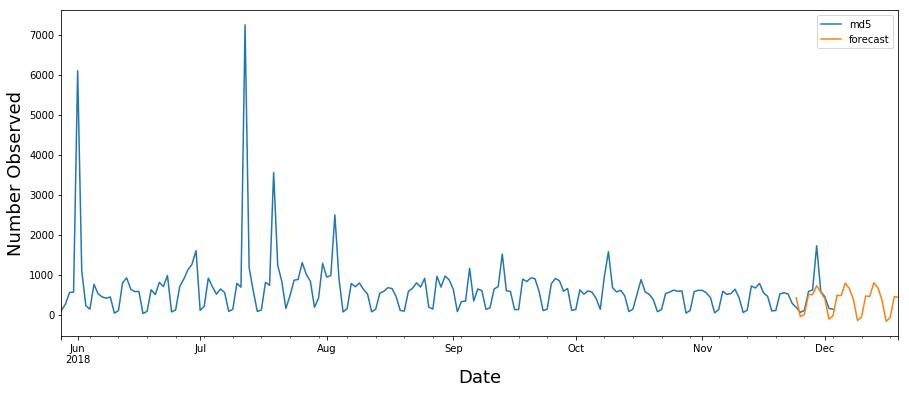

In [21]:
#plot with matplotlib
ax = df_y.plot(label='observed', figsize=(15, 6))
pred_results.plot(ax=ax, label='forecast')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number Observed', fontsize=18)
plt.legend()

predict results in a time series <br>
plot both the lines on matplotlib<br>
point out there is seriously failed <br>
show it requires a transform to prevent from going negative<br>


In [22]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from math import pi # not cake
output_notebook()

df_bokeh = df_y.reset_index()

p = figure(x_axis_label ='Date', y_axis_label ='Count', x_axis_type='datetime', plot_width=900)

p.line(df_bokeh['date'], df_bokeh['md5'])

df_prediction = pred_results.to_frame().reset_index().rename(columns={'index':'date', 0:'md5'})

p.line(df_prediction['date'], df_prediction['md5'], color = 'orange')

p.xaxis.axis_label_text_font_size = '18pt'
p.yaxis.axis_label_text_font_size = '18pt'
p.xaxis.major_label_orientation = pi/4

Loading BokehJS ...

In [23]:
show(p)

pretty version in bokeh<br>
typical meant for server graph stuff <br>
allows scrolling and export<br>
supports buttons and dropdowns <br>

In [24]:
import seaborn as sns
df_bokeh['type'] = 'actuals'
df_prediction['type'] = 'predictions'
df_plt = pandas.concat([df_bokeh,df_prediction])

Text(0, 0.5, 'Count')

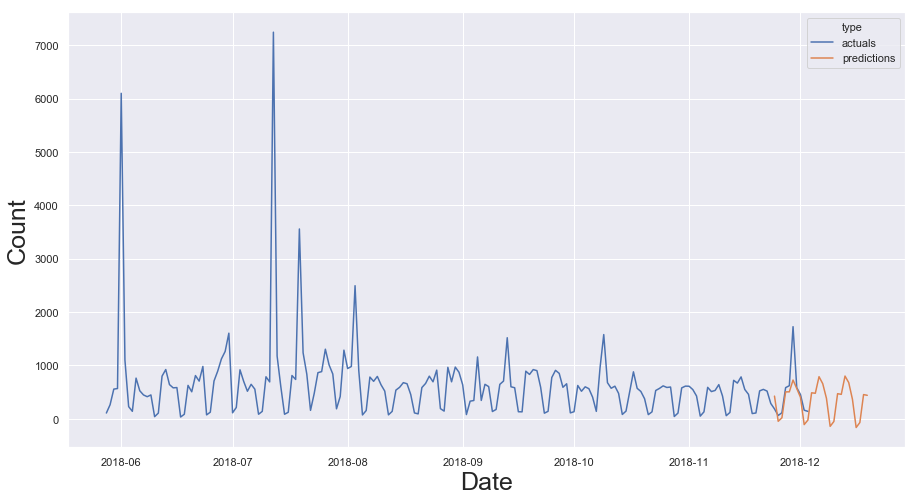

In [25]:
sns.set(rc={'figure.figsize':(15,8)})
pretty = sns.lineplot(x="date", y="md5", hue='type', data=df_plt)
pretty.set_xlabel("Date",fontsize=25)
pretty.set_ylabel("Count",fontsize=25)

plot in seaboard - matplotlib overlay<br>
reduced to one line<br>
required that dataframe had a column label/hue<br>

<IMG src="./images/Notebook/Slide11.jpeg">

<IMG src="./images/Notebook/Slide12.jpeg">

In [26]:
%run /Users/c266770/Desktop/notebooks/proxy-load.ipynb

another magic command<br>
this one run scripts and pull the globals into the existing scripts for use<br>
libraries without the formality<br>

In [27]:
def vt_call(hashes):
    from time import sleep
    headers = {"Accept-Encoding": "gzip, deflate", "User-Agent" : "python"}
    result_dict = {};counter = 1
    if type(hashes) == list:
        hashes = list(zip(range(1,len(hashes) + 1), hashes))
        lookupList = []
        for lookupTuple in hashes:
            lookupList.append(lookupTuple[1])
            if (lookupTuple[0] % 4 == 0) | (lookupTuple[1] == hashes[-1][1]):
                print('Request number '+str(counter)+' to virustotal'); counter += 1
                params = {'apikey': api['vt'], 'resource': ','.join(lookupList)}
                request = requests.get('https://www.virustotal.com/vtapi/v2/file/report',
                                       params = params, 
                                       headers = headers,
                                       proxies = proxies).json()
                for result in ([request] if type(request) != list else request):
                    try:
                        result_dict[result['md5']] = result
                        del result_dict[result['md5']]['scans']
                        del result_dict[result['md5']]['md5']
                    except:
                        result_dict[result['md5']] = {'response_code': 1}
                sleep(60)
                lookupList = []
            else:
                continue
        return result_dict
    else:
        raise TypeError('input must be a python list')      

a larger function - but not in third version since drafting the presentation<br>
accepts only a lists<br>
if string is comma seperate make into list<br>
creates a counter and iterates through the list that has been made into a tuple <br>
pulls in api key from pickle<br>
finds the response from virustotal and combines them<br>


In [28]:
test = ['866fcd320412a9fdd78aefc31372c74e', #Filezilla
        '29c1a72fa565f339065d1f6c8a58de11', #Fake AV - Ming web report
        '38acd35c1b04167823c83bbd8a12352c', #Packer - RDPOn.exe
        '28b78a1ab9f541a0a85cb853eb556fe8', #Adware - Coupons
        'ac8c1fa592b1551fd57072c371b7c748'] #Asparnet

vt_results = vt_call(test)

Request number 1 to virustotal
Request number 2 to virustotal


list of hashes with 5. <br>
returned back into vt_results as a dictionary <br>
remove some of the crazy scan stuff <br>

In [29]:
for key, value in vt_results.items():
    print(key,value['positives'])

866fcd320412a9fdd78aefc31372c74e 19
29c1a72fa565f339065d1f6c8a58de11 15
38acd35c1b04167823c83bbd8a12352c 13
28b78a1ab9f541a0a85cb853eb556fe8 17
ac8c1fa592b1551fd57072c371b7c748 19


prints out the hash <br>
prints out the positives <br>

In [30]:
import pandas
import os
some_directory = '/tmp'

df_hashes = pandas.DataFrame.from_dict(vt_results, orient='index')
df_hashes.to_excel(os.path.join(some_directory,'hashes.xls'))
json_hashes = df_hashes.to_json()
df_hashes[['total','positives']].head(5)

,total,positives
28b78a1ab9f541a0a85cb853eb556fe8,68,17
29c1a72fa565f339065d1f6c8a58de11,67,15
38acd35c1b04167823c83bbd8a12352c,66,13
866fcd320412a9fdd78aefc31372c74e,68,19
ac8c1fa592b1551fd57072c371b7c748,67,19


convert the dictionary to a pandas dataframe<br>
pandas allows easy export to excel and json<br>

<IMG src="./images/Notebook/Slide13.jpeg">

<IMG src="./images/Notebook/Slide3.jpeg">

In [ ]:
import http.server
import socketserver

PORT = 8256

os.chdir('.')

Handler = http.server.SimpleHTTPRequestHandler

with socketserver.TCPServer(("", PORT), Handler) as httpd:
    print("serving at port", PORT)
    httpd.serve_forever()

Due to the web resources/browser needed to facilitate this presentation, it was exported to a PDF for your review. Unfortunately, the speaker notes in this export overlapped the slides on certain pages. This was my only serious technical issue in crafting this newer content.

As the conference approaches and the presentation finalized. It will be shared on github without the underlying data to facilitate graphs etc.

Another possibility presently being explored is allowing the audience some participation with AWS SageMaker, Azure Notebooks, or Google Cloud Datalab. This also was not accomplished with the original presentation with the Indianapolis SOC meetup.

Thanks for your review and please contact me with any thoughts.
Toby
hendricks_tobias@lilly.com

The attached is a revised presentation that was presented to Indianapolis SOC members in regards to notebooks. 

Since the original presentation, it was discovered that Jupyter [which is a notebook technology] has a capability to export to slides using reveal.js [a Powerpoint like presentation software that makes items web available]. 

The advantage in using reveal.js is:
* The Python code and plots in this demonstration can be easily presented without screenshots.
* Graphs and visualizations are displayed without exporting from the notebook and attaching into Powerpoint slides.
* Edits to the presentation can be conducted with relative ease.
* The look and feel of a reveal.js presentation has a certain Prezi attributes. See reveal.js here.
* The content, as code, can be easily shared via github. This will allow interested participates to cut/paste code snips for their use. As such, the content of the code has been scrubbed of Lilly specific technologies.
* It’s good to be different. It won’t be ‘just another Powerpoint’ presentation

In [ ]:
import requests

#function for calling vt - requests based
def vt_call(hashes):
    from time import sleep 
    
    #test the list
    if type(hashes) == list:
        if len(hashes) < 5:
            resource = ','.join(hashes)
                
        elif len(hashes) >= 5:
            resource = [hashes[i:i + 4] for i in range(0, len(hashes), 4)]
        else:
            return 'empty list?'
    elif type(hashes) == str and len(hashes.split(',')) == 1:
        resource = hashes
    elif type(hashes) == str and len(hashes.split(',')) < 4:
        resource = hashes
    elif type(hashes) == str and len(hashes.split(',')) > 4:
        #break things up if bigger than 4
        hashes = hashes.split(',')
        resource = [hashes[i:i + 4] for i in range(0, len(hashes), 4)]
    else:
        return ''
    
    headers = {"Accept-Encoding": "gzip, deflate",
               "User-Agent" : "python"
              }
    
    if type(resource) != list:
        params = {'apikey': api['vt'], 'resource': resource}
        response = requests.get('https://www.virustotal.com/vtapi/v2/file/report',
                                params = params, 
                                headers = headers,
                                proxies = proxies)
        return response.json()
    else:
        response = []
        for hash_list in resource:
            params = {'apikey': api['vt'], 'resource': ','.join(hash_list)}
            vt_request = requests.get('https://www.virustotal.com/vtapi/v2/file/report',
                                      params = params,
                                      headers = headers,
                                      proxies = proxies)
            new_stuff = vt_request.json()
            #todo: sleep if too many
            if type(new_stuff) == dict:
                temp_list = []
                temp_list.append(new_stuff)
                #combine the responses
                response = response + temp_list
            else:
                response = response + new_stuff
            
        return response